# QP constrained optimization test

This notebook demonstrates the QP-based gradient descent algorithm described in https://arxiv.org/abs/2412.13403.

In [8]:
from typing import Callable

import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

Create objective function and constraint.

In [9]:
def objective_function(x: torch.Tensor) -> torch.Tensor:
    return torch.sum(torch.square(x))

In [10]:
def constraint_function(x: torch.Tensor) -> torch.Tensor:
    xn = x - torch.tensor([2.0, 2.0])
    return torch.norm(xn) - 1.0

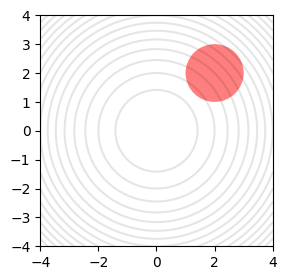

In [11]:
xmax = 4.0
grid_coords = 2 * [torch.linspace(-xmax, xmax, 100)]
grid_points = torch.stack([c.ravel() for c in torch.meshgrid(*grid_coords, indexing="ij")], axis=-1)

grid_values = torch.zeros(grid_points.shape[0])
for i, x in enumerate(grid_points):
    grid_values[i] = objective_function(x)
grid_values = torch.reshape(grid_values, (100, 100))

fig, ax = plt.subplots(figsize=(3, 3))
ax.contour(grid_coords[0], grid_coords[1], grid_values.T, colors="black", levels=20, alpha=0.1)
ax.add_patch(Circle([2.0, 2.0], 1.0, color="red", ec="none", alpha=0.5))
ax.set_xlim(-xmax, xmax)
ax.set_ylim(-xmax, xmax)
plt.show()

Optimize using QP method.

In [12]:
def step_optimizer(
    optimizer: torch.optim.Optimizer, 
    objective_function: Callable, 
    constraint_function: Callable,
    x: torch.Tensor,
    c: float = 1.0,
    eps: float = 1.00e-12
) -> None:
    """Step optimizer using mixed gradient."""    
    optimizer.zero_grad()
    
    f = objective_function(x)    
    f.backward()
    grad_f = x.grad.clone().detach()

    x.grad.zero_()
    
    g = constraint_function(x)
    g.backward()
    grad_g = x.grad.clone().detach()
    
    with torch.no_grad():
        alpha = max(0.0, -torch.dot(grad_f, grad_g) + c * g) / max(eps, torch.linalg.norm(grad_g)**2)
        x.grad = grad_f + alpha * grad_g
        optimizer.step()

In [13]:
x = torch.tensor([3.0, -3.0], requires_grad=True)
c = torch.tensor(4.0)  # rate of approach to constraint boundary

optimizer = torch.optim.Adam([x,], lr=0.1)

path = [x.clone().detach()]
for i in range(100):
    step_optimizer(optimizer, objective_function, constraint_function, x, c)
    path.append(x.clone().detach())
path = torch.stack(path)

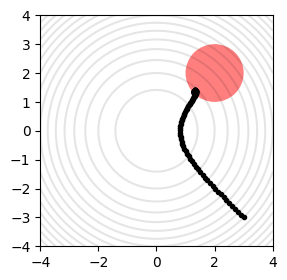

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.contour(grid_coords[0], grid_coords[1], grid_values.T, colors="black", levels=20, alpha=0.1)
ax.add_patch(Circle([2.0, 2.0], 1.0, color="red", ec="none", alpha=0.5))
ax.plot(path[:, 0], path[:, 1], color="black", marker=".")
ax.set_xlim(-xmax, xmax)
ax.set_ylim(-xmax, xmax)
plt.show()